# Pytorch Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m12sl/short-dl/blob/master/02-pytorch/pytorch-train-loop.ipynb)

В этой тетрадке мы напишем познакомимся с базовыми возможностями pytorch.

**Цели тетрадки**

1. Познакомиться с типами данных и арифметикой в pytorch.
1. Научиться пользоваться автоматическим дифференцированием.
1. Попробовать low-level и high-level API на нескольких задачах.



**План работы**

1. Познакомиться на примерах с pytorch API.
1. Научиться получать градиенты для переменных.
1. Реализовать линейную регрессию на pytorch.
1. Натренировать классификатор FashionMNIST с помощью high-level API.
1. Зафайнтюнить предобученную модель из пакета torchvision.


## Материалы по pytorch:

+ https://pytorch.org/resources/
+ https://pytorch.org/docs/stable/index.html
+ ходить по исходникам с помощью IDE
+ [Классная статья про pytorch internal](http://blog.ezyang.com/2019/05/pytorch-internals/)


## Важные модули:

- `autograd` -- функции для вычисления производных
- `nn`-- классы для слоев и моделей
- `nn.functional` -- функциональный API для некоторых операций
- `nn.init` -- различные варианты инциализации
- `optim` -- оптимизаторы
- `utils.data` -- API для работы с данными (Dataset & DataLoader)


**Дополнительные пакеты:**
- `torchvision` -- предобученные модели, преобразования картинок и датасеты
- `torchaudio` -- датасеты и полезные преобразования для работы со звуком
- `torchtext` -- датасеты и полезные функции для работы с текстом

In [1]:
# install requirements
! pip install torchviz torchvision

In [2]:
%matplotlib inline
from collections import defaultdict

from IPython.display import clear_output  # потребуется для перерисовки графиков
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchviz  # потребуется для отображения графов
from tqdm.auto import tqdm

## Основа вычислений: torch.Tensor


Это практически `numpy.ndarray` с некоторыми дополнительными возможностями.

Официальная документация: https://pytorch.org/docs/stable/tensors.html


**Важные поля:**
- `.device` -- `cuda` или `cpu`
- `.dtype` -- тип переменной, в отличие от numpy, преобразования типов приходится делать явно
- `.requires_grad` -- флаг говорит, должен ли автоград вычислять градиенты для этой переменной
- `.data` -- содержимое переменной
- `.grad` -- градиенты, сохраненные для этой переменной





In [3]:
# numpy world
x = np.arange(16).astype(np.float32).reshape(4, 4)

print("X :\n %s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", np.dot(x, x.T))
print("mean over cols :\n%s" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s" % (np.cumsum(x, axis=0)))

X :
 [[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]
add 5 :
[[ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]
 [17. 18. 19. 20.]]
X*X^T  :
 [[ 14.  38.  62.  86.]
 [ 38. 126. 214. 302.]
 [ 62. 214. 366. 518.]
 [ 86. 302. 518. 734.]]
mean over cols :
[ 1.5  5.5  9.5 13.5]
cumsum of cols :
[[ 0.  1.  2.  3.]
 [ 4.  6.  8. 10.]
 [12. 15. 18. 21.]
 [24. 28. 32. 36.]]


In [4]:
# pytorch world
x = torch.arange(16).float().view(4, 4)

print("X :\n%s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", torch.matmul(x, x.transpose(1, 0)))
print("mean over cols :\n", torch.mean(x, dim=-1))
print("cumsum of cols :\n", torch.cumsum(x, dim=0))

X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T  :
 tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols :
 tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


Numpy и Pytorch не требуют описания статического графа вычислений.
Результат получается сразу при выполнении.

**Можно отлаживаться с помощью pdb/ipdb или просто print.**

API несколько различается:

|        numpy        |      pytorch    |
|:-------             |         -------:|
| `x.reshape([1,2,8])`| `x.view(1,2,8)` |
| `x.sum(axis=-1)`    | `x.sum(dim=-1)` |
| `x.astype('int64')` | `x.type(torch.int64)` |


Легко конвертировать между собой:

```python
tt = torch.from_numpy(npx) # -- вернет Tensor
npx = tt.numpy() # -- вернет Numpy Array
```

Преобразовать тензор из одного числа в обычное питоновское число:
```python
torch.tensor([1]).item() # 1
```

**NB: тензор тащит за собой весь вычислительный граф, чтобы можно было сделать backward, так при откладывании чисел (например для логов) обязательно доставайте сами числа, не складывайте тензора в массивы между итерациями -- это приведет к утечке памяти**

## Вычислительный граф

Вычислительный граф строится по выражениям, в которых участвует `torch.tensor`.

Все вершины в графе можно разбить на два класса: Leaf (листовые) и Non-Leaf (не листовые) вершины. 

Если тензор не зависит от других, он является листовой вершиной.

Для оптимизации памяти pytorch будет считать градиенты только для _листовых_ переменных с выставленным флагом `requires_grad=True`:

tensor([ -2.,  -6., -12., -20.], grad_fn=<MulBackward0>)


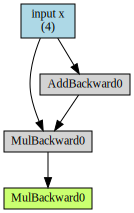

In [5]:
x = torch.tensor([1., 2., 3., 4.], requires_grad=True)  # leaf tensor
alpha = torch.tensor([-1.0, ]) # leaf, but without grads
y = x + 1  # not a leaf variable
z = x * y * alpha
print(z)


torchviz.make_dot(z, {"input x": x})

In [6]:
x = torch.tensor([1., 2., 3., 4.], requires_grad=True)  # leaf tensor
alpha = torch.tensor([-1.0, ]) # leaf, but without grads
y = x + 1  # not a leaf variable
loss = (alpha * y).mean()

print("BEFORE BACKWARD")
[print(f"var: {var}\ngrad: {var.grad}\n") for var in [x, y, alpha]]

loss.backward()
print("\nAFTER BACKWARD:")
[print(f"var: {var}\ngrad: {var.grad}\n") for var in [x, y, alpha]]

    
# просто так повторно запросить .backward() нельзя, попробуйте раскомментить:
# loss.backward()

# но можно сделать еще один тензор (зависящий от предыдущих переменных) и запросить .backward() в нем:
loss2 = (alpha * y).mean()
loss2.backward()

print("\nAFTER BACKWARD2:")
[print(f"var: {var}\ngrad: {var.grad}\n") for var in [x, y, alpha]]

BEFORE BACKWARD
var: tensor([1., 2., 3., 4.], requires_grad=True)
grad: None

var: tensor([2., 3., 4., 5.], grad_fn=<AddBackward0>)
grad: None

var: tensor([-1.])
grad: None


AFTER BACKWARD:
var: tensor([1., 2., 3., 4.], requires_grad=True)
grad: tensor([-0.2500, -0.2500, -0.2500, -0.2500])

var: tensor([2., 3., 4., 5.], grad_fn=<AddBackward0>)
grad: None

var: tensor([-1.])
grad: None


AFTER BACKWARD2:
var: tensor([1., 2., 3., 4.], requires_grad=True)
grad: tensor([-0.5000, -0.5000, -0.5000, -0.5000])

var: tensor([2., 3., 4., 5.], grad_fn=<AddBackward0>)
grad: None

var: tensor([-1.])
grad: None



<ipython-input-6-256975be031c>:7: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  [print(f"var: {var}\ngrad: {var.grad}\n") for var in [x, y, alpha]]
<ipython-input-6-256975be031c>:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  [print(f"var: {var}\ngrad: {var.gra

[None, None, None]

Итак, как пользоваться автоматическим дифференцированием:

1. Создать переменную: `a = torch.tensor(..., requires_grad=True)`

2. Определить какую-нибудь дифференцируемую функцию `loss = whatever(a)`

3. Запустить backward-проход `loss.backward()`

4. Градиенты будут доступны в `a.grad`

5. При повторных вызовах `.backward()` (у разных лоссов) градиенты в задействованных переменных суммируются. Это позволяет использовать несколько функций ошибок или виртуально увеличивать `batch_size`. Поэтому, перед каждый вычислением градиентов, стоит обнулять старые градиенты.

**NB: вычисление градиентов работает только для тензоров с вещественным типом данных**

In [7]:
# will not work
x = torch.tensor([1, 2, 3, 4], requires_grad=True)

RuntimeError: Only Tensors of floating point and complex dtype can require gradients

Чтобы выключить автоматическое вычисление градиентов, есть три возможности:
- выставить `requires_grad=False`
- использовать контекст-менеджер `with torch.no_grad()`
- применить `detach`:

In [8]:
t = torch.tensor([1.0, 0.5])
x = torch.tensor([1.], requires_grad=True)
y = x**2
print(t.requires_grad)
print(x.requires_grad)
print(y.requires_grad)

with torch.no_grad():
    z = torch.exp(x)
    print(z.requires_grad)
    
# detach from the graph
w = torch.log(x).detach()
print(w.requires_grad)

False
True
True
False
False


# Линейная регрессия

Рассмотрим пример линейной регрессии на датасете Boston. 

Для простоты оставим одну компонету признаков:

(506, 13)


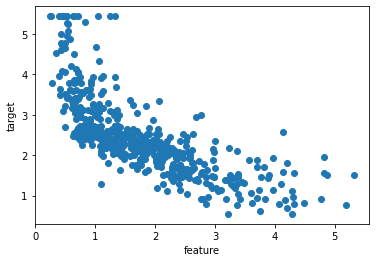

In [9]:
from sklearn.datasets import load_boston

X, Y = load_boston(return_X_y=True)
print(X.shape)
X = X[:, -1] / X[:, -1].std()
Y = Y / Y.std()

plt.figure()
plt.scatter(X, Y)
plt.ylabel("target")
plt.xlabel("feature")
plt.show()

Нужно провести прямую линию, минимизирующую MSE.
Запишем вычислительный граф и получим градиенты для одного шага градиентного спуска:

dL/dw = 
 tensor([-7.2240])
dL/db = 
 tensor([-4.9048])


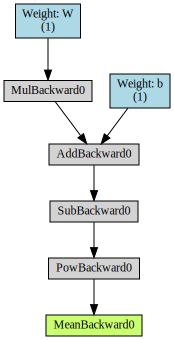

In [10]:
# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# data tensors
x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(Y).type(torch.float)

y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

loss.backward()

#now w.grad is a tensor containing gradient of L w.r.t. w
print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)


torchviz.make_dot(loss, {"Weight: W": w, "Weight: b": b})

Предлагается реализовать обучение модели линейной регрессии.

**Напишите код для обновления весов:**

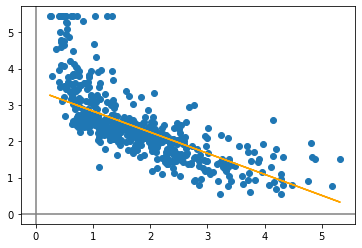

loss =  0.4857395589351654
Done!


In [11]:
x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(Y).type(torch.float)

# learning rate
alpha = 0.1

for i in range(100):    
    # напишите шаг градиентного спуска
    # forward pass
    y_pred = w * x + b
    loss = torch.mean((y_pred - y)**2)
    # calculate gradients
    loss.backward()
    # apply learning step
    w.data.sub_(alpha * w.grad.data)
    b.data.sub_(alpha * b.grad.data)
    
    # zero gradients
    w.grad.zero_()
    b.grad.zero_()
    
    # the rest of code is just bells and whistles
    if (i + 1) % 5==0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(),y.numpy())
        plt.plot(x.numpy(),y_pred.data.numpy(),color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

# Optimizers

В этом примере мы пользовались простым правилом для градиентного спуска:
  
$$\theta^{n+1} = \theta^{n} - \alpha \nabla_{\theta}L$$


Единственным параметром в нем является $\alpha$ -- это `learning_rate`.

На практике часто используют различные модификации (например _Momentum_):

$$\theta^{n+1} = \theta^{n} - U^{n}\\
U^{n} = \gamma U^{n-1} + \alpha \nabla_{\theta}(L)
$$

Хороший обзор алгоритмов оптимизации для сетей можно посмотреть [тут](http://ruder.io/optimizing-gradient-descent/).



Pytorch предоставляет практически все широкораспространненные оптимизаторы:    
http://pytorch.org/docs/master/optim.html




Оптимизаторы очень просто использовать:

- при создании оптимизатора требуется указать список переменных, с которыми он будет работать
- `opt.zero_grad()` сбрасывает градиенты
- `opt.step()` применяет `update` ($U^{n}$) к весам

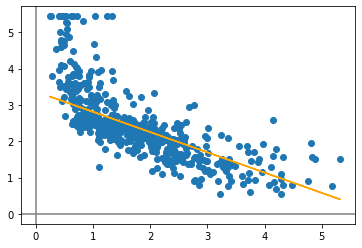

loss =  0.49351754784584045
Done!


In [12]:
# get data
x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(Y).type(torch.float)
# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# define optimizer
opt = torch.optim.RMSprop([w, b], lr=0.1)

for i in range(100):
    # compute loss
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y) ** 2)
    
    # backprop and gradient descent
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    
    #the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), y_pred.data.numpy(), color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

## Highlevel-API 

При работе с нейронными сетями становится неудобно контролировать переменные с весами по-отдельности. 
Pytorch предоставляет высокоуровневый API для моделей: [nn.Module](http://pytorch.org/docs/master/nn.html#torch.nn.Module)

Чтобы воспользоваться моделью необходимо отнаследоваться от `torch.nn.Module`, определить слои и описать `forward`. 

`backward` будет вычислен автоматически.

In [13]:
# Higher-level API:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, in_channels=784, hidden_size=40):
        super(Net, self).__init__()
        # here you construct weights for layers
        self.fc1 = nn.Linear(in_channels, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        # важно чтобы слои записывались как методы класса
        # self.some_layers = [nn.Linear(), nn.Linear(), ...] сломает разные полезные из-коробочные функции
        # Если очень нужно, есть специальный класс nn.ModuleList
        
    def forward(self, x):
        # here you describe usage of layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)
    # backward function computes automaticaly


net = Net()
net(torch.rand(3, 784))

tensor([[-2.0842, -2.2083, -2.4376, -2.2139, -2.3689, -2.5070, -2.3849, -2.3277,
         -2.3297, -2.2348],
        [-2.0655, -2.1927, -2.4260, -2.2091, -2.3627, -2.5102, -2.4254, -2.3185,
         -2.3948, -2.2076],
        [-2.0737, -2.1829, -2.3902, -2.2218, -2.3964, -2.5250, -2.3975, -2.3345,
         -2.3798, -2.2066]], grad_fn=<LogSoftmaxBackward>)

Простую цепочку слоев удобно заворачивать в `nn.Sequential`.
В таком случае не придется писать `.forward`

In [14]:
net = nn.Sequential(
    nn.Linear(784, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 10),
    nn.LogSoftmax(dim=1),
)
net(torch.rand(32, 784)).shape

torch.Size([32, 10])

В качестве датасета возьмем FashionMNIST

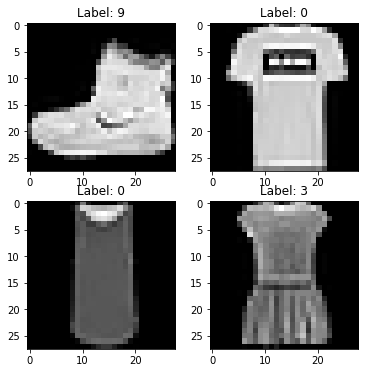

In [15]:
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms


default_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda t: t.reshape(-1))]  # let's convert image (28, 28) to vector (784)
)
train_dataset = FashionMNIST("./tmp", train=True, download=True, transform=default_transform)
val_dataset = FashionMNIST("./tmp", train=False, download=True, transform=default_transform)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=32)

train_dataset[0][0].shape
plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % train_dataset[i][1])
    plt.imshow(train_dataset[i][0].reshape(28, 28), cmap='gray')  # don't forget convert vector to image

**Напишите код для тренировки по аналогии с обучением линейной регрессии и прошлой тетрадки**

Предлагается для треккинга экспериментов использовать [`defaultdict`](https://docs.python.org/3.3/library/collections.html#defaultdict-objects)

**NB: обязательно доставайте числа из тензоров, не сохраняйте тензора с каждой итерации в какой-нибудь буффер.
Каждый тензор тащит за собой информацию для построения графа, это ест память**

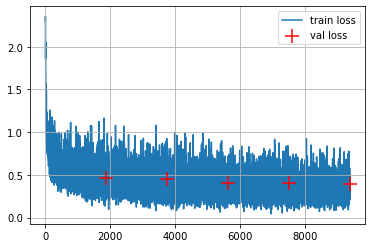

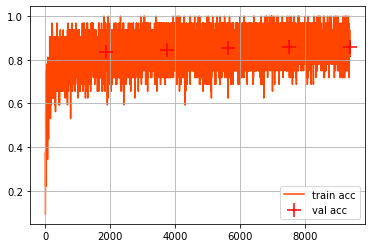

Sequential(
  (0): Linear(in_features=784, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): ReLU()
  (4): Linear(in_features=40, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [16]:
def train_model(model, opt, trainloader, valloader, epochs=1):
    step = 0
    logs = defaultdict(list)
    loss_function = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        for batch in tqdm(trainloader):
            # тренировочные шаги
            # zero out gradients from previous iteration
            opt.zero_grad()
            # forward pass
            logits = model.forward(batch[0])
            # calculate loss function
            loss = loss_function(logits, batch[1])
            # backpropagation - calculate gradients
            loss.backward()
            # optimizer step (on all model parameters)
            opt.step()
            
            # добавьте точность и ошибку в логи
            logs['acc'].append(np.mean(np.argmax(logits.detach().numpy(), axis=-1) == batch[1].detach().numpy()))
            logs['loss'].append(loss)
            step += 1
            
        model.eval()
        tmp = defaultdict(list)  # аккумулятор для накопления и усреднения результатов за валидацию
        with torch.no_grad():
            for batch in tqdm(valloader):
                # валидационные шаги
                opt.zero_grad()
                logits = model.forward(batch[0])
                loss = loss_function(logits, batch[1])
                # добавьте точность и ошибку в логи
                tmp['acc'].append(np.mean(np.argmax(logits.detach().numpy(), axis=-1) == batch[1].detach().numpy()))
                tmp['loss'].append(loss)
        for key, values in tmp.items():
            logs[f"val_{key}"].append(np.mean(values))
        logs["step"].append(step)
        
        clear_output(True)
        # Loss chart
        plt.figure()
        plt.plot(logs['loss'], label='train loss', zorder=1)
        plt.scatter(logs["step"], logs['val_loss'], marker='+', s=180, c='#FF0000', label='val loss', zorder=10)
        plt.grid()
        plt.legend()
        plt.show()
        # Accuracy chart
        plt.figure()
        plt.plot(logs['acc'], c='#FF4500', label='train acc', zorder=1)
        plt.scatter(logs["step"], logs['val_acc'], marker='+', s=180, c='#FF0000', label='val acc', zorder=10)
        plt.grid()
        plt.legend()
        plt.show()
    return model


model = nn.Sequential(
    nn.Linear(784, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 10),
    nn.LogSoftmax(dim=1),
)
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
    

train_model(model, opt, train_loader, val_loader, epochs=5)

## Fine Tuning


Для многих прикладных задач не существует больших датасетов с хорошей разметкой. 
Поэтому распространенным приемом является тренировка на похожем, но большом датасете и доучивание сети на целевом.

Такой прием называют **Transfer Learning** или **Finetuning**.

В сверточных сетях для классификации выделяют две части:
- тело сети -- feature extractor, набор сверток и пулингов (convolutions and poolings)
- голову -- это MLP (набор полносвязных слоев) после которых делается softmax и получаются вероятности разных классов.


Вычислительно простым вариантом finetuning является обучение головы при замороженном feature extractor'е.

Нам потребуется [предобученная модель](http://pytorch.org/docs/master/torchvision/datasets.html#torchvision-datasets) и датасет для нашей задачи.

Предлагается воспользоваться моделью обученной на Imagenet, а в качестве целевого взять [Imagenette (это небольшое простое подмножество Imagenet)](https://github.com/fastai/imagenette)

Архив с картинками доступен на
https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz

**Не запускайте на медленном канале! Весит ~95Mb**

In [19]:
! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz --no-check-certificate
! tar xf imagenette2-160.tgz

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2020-08-26 11:37:56--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Распознаётся s3.amazonaws.com... 52.216.249.134
Устанавливается соединение с s3.amazonaws.com|52.216.249.134|:443... соединение установлено.
ПРЕДУПРЕЖДЕНИЕ: невозможно проверить сертификат s3.amazonaws.com, запрошенный `/C=US/O=DigiCert Inc/OU=www.digicert.com/CN=DigiCert Baltimore CA-2 G2':
  Невозможно локально проверить подлинность запрашивающего.
Запрос HTTP послан, ожидается ответ... 200 OK
Длина: 98948031 (94M) [application/x-tar]
Сохраняется в каталог: `imagenette2-160.tgz'.

     0K .......... .......... .......... .......... ..........  0%  199K 8m4s
    50K .......... .......... .......... .......... ..........  0%  391K 6m5s
   100K .......... .......... .......... .......... ..........  0%  385K 5m27s
   150K .......... .......... .......... .......... ..........  0%  385K 5m8s
   200K ....

В файловой системе должны появиться папки:
```bash
$ tree --filelimit 10
├── imagenette2-160
│   ├── train
│   │   ├── n01440764 [963 entries exceeds filelimit, not opening dir]
│   │   ├── n02102040 [955 entries exceeds filelimit, not opening dir]
│   │   ├── n02979186 [993 entries exceeds filelimit, not opening dir]
│   │   ├── n03000684 [858 entries exceeds filelimit, not opening dir]
│   │   ├── n03028079 [941 entries exceeds filelimit, not opening dir]
│   │   ├── n03394916 [956 entries exceeds filelimit, not opening dir]
│   │   ├── n03417042 [961 entries exceeds filelimit, not opening dir]
│   │   ├── n03425413 [931 entries exceeds filelimit, not opening dir]
│   │   ├── n03445777 [951 entries exceeds filelimit, not opening dir]
│   │   └── n03888257 [960 entries exceeds filelimit, not opening dir]
│   └── val
│       ├── n01440764 [387 entries exceeds filelimit, not opening dir]
│       ├── n02102040 [395 entries exceeds filelimit, not opening dir]
│       ├── n02979186 [357 entries exceeds filelimit, not opening dir]
│       ├── n03000684 [386 entries exceeds filelimit, not opening dir]
│       ├── n03028079 [409 entries exceeds filelimit, not opening dir]
│       ├── n03394916 [394 entries exceeds filelimit, not opening dir]
│       ├── n03417042 [389 entries exceeds filelimit, not opening dir]
│       ├── n03425413 [419 entries exceeds filelimit, not opening dir]
│       ├── n03445777 [399 entries exceeds filelimit, not opening dir]
│       └── n03888257 [390 entries exceeds filelimit, not opening dir]
...
```

In [17]:
from torchvision.datasets import ImageFolder

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(160),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder("./imagenette2-160/train/", transform=train_transform)
val_dataset = ImageFolder("./imagenette2-160/val/", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

**Выведите несколько примеров из train_dataset с метками.**

**NB: Обратите внимание на преобразования, которые мы делаем над картинками и предупреждения, которые выдает `plt.imshow`**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

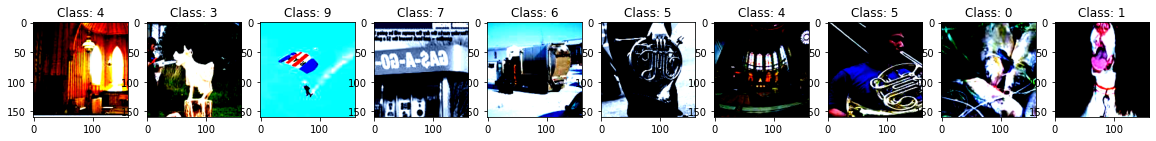

In [18]:
iterator = iter(train_loader)
X, y = next(iterator)

n_samples = 10
fig, axs = plt.subplots(nrows=1, ncols=n_samples, figsize=(20, 20))
for i in range(n_samples):
    axs[i].set_title(f"Class: {y[i]}")
    axs[i].imshow(np.transpose(X[i], (1, 2, 0)))

**Модифицируйте модель так, чтобы она выдавала логиты на 10 классов, выберете для обучения только параметры измененного слоя.**

Пояснение: все именнованные слои доступны как методы модели, если в `model_ft` есть слой `very_layer` его можно получить (и модифицировать) по имени:
```
print(model_ft.very_layer)
model_ft.very_layer = nn.SomeLayer(...)
```

Все слои инициализируются в момент создания. Кроме того можно вызвать инициализацию руками, например так:
```
very_layer.weight.data.fill_(0.01)
```

Или воспользоваться уже написанными методами инициализации из модуля `torch.nn.init`
```
torch.nn.init.xavier_uniform(very_layer.weight)
```

In [19]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
# hint: вы можете изучить устройство любого объекта в python пользуясь интерактивностью интерпретатора и методом dir()

# Список слоев модели можно получить с помощью обхода
# for x in model_ft.named_modules():
#    print(x[0], x[1])

# TODO: подмените в модели последний слой, чтобы она работала для 10 классов
print('Before: ', list(model_ft.named_modules())[-1])
# <your code>
model_ft.fc = nn.Linear(in_features=512, out_features=10, bias=True)
print('After: ', list(model_ft.named_modules())[-1])

# # TODO: выберите, какие параметры дообучать.
# # для ускорения работы не забудьте выключить подсчёт градиента для всех необучаемых параметров 
# # например, выключить обучение всех параметров можно при помощи этого кода:
for params in model_ft.parameters():
    params.requires_grad = False 

params_to_train = list(model_ft.fc.parameters())
for params in params_to_train:
    params.requires_grad = True 

optimizer = torch.optim.SGD(params_to_train, lr=0.001, momentum=0.9)

Before:  ('fc', Linear(in_features=512, out_features=1000, bias=True))
After:  ('fc', Linear(in_features=512, out_features=10, bias=True))


Чтобы воспользоваться GPU необходимо перенести модель и тензоры на устройство 'cuda'.
Это делается с помощью операции `.to`:
```
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
x = x.to(device)
y = y.to(device)
```

Если что-то пойдет не так и тензоры окажутся на разных устройствах, просто вылетит исключение.
Если у вас есть доступ к GPU, модифицируйте тренировочный цикл (функцию train_model) так, чтобы он мог работать и на GPU. Это существенно ускорит эксперименты.

**Проведите несколько экспериментов:**
- Случайная инициализация добавленного слоя + замороженный feature extractor
- Случайная инициализация добавленного слоя + обучаемый feature extractor
- Нулевая инициализация добавленного слоя + обучаемый feature extractor

In [93]:
# optional: перепишите тренировочный цикл для работы на GPU
def train_model(model, optimizer, trainloader, valloader, epochs=10, device='cpu'):
    # делаю на ноуте без GPU
    pass

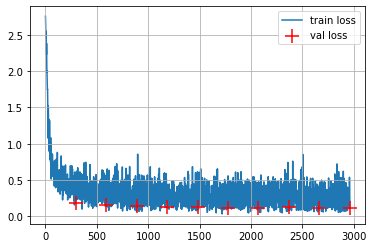

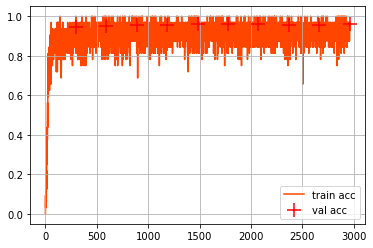

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# random init + frozen FE
model_ft = models.resnet18(pretrained=True)
# Соберите модель правильно
# replace final layer, random initialization
model_ft.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# freeze feature extractor learning
for params in model_ft.parameters():
    params.requires_grad = False 
# but keep learning the final layer
params_to_train = list(model_ft.fc.parameters())
for params in params_to_train:
    params.requires_grad = True 

optimizer = torch.optim.SGD(params_to_train, lr=0.001, momentum=0.9)
train_model(model_ft, optimizer, train_loader, val_loader, epochs=10)

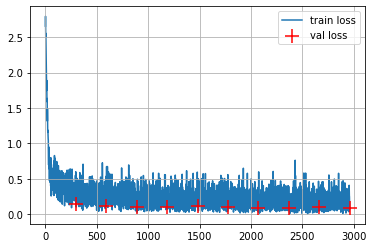

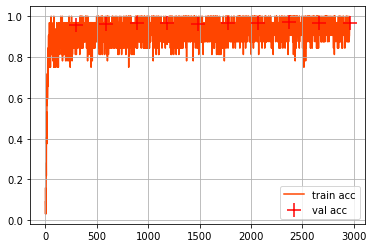

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# random init + trainable FE
model_ft = models.resnet18(pretrained=True)
# Соберите модель правильно
# replace final layer, random initialization
model_ft.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# trainable feature extractor
for params in model_ft.parameters():
    params.requires_grad = True

optimizer = torch.optim.SGD(list(model_ft.parameters()), lr=0.001, momentum=0.9)
train_model(model_ft, optimizer, train_loader, val_loader, epochs=10)

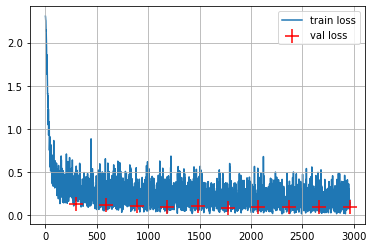

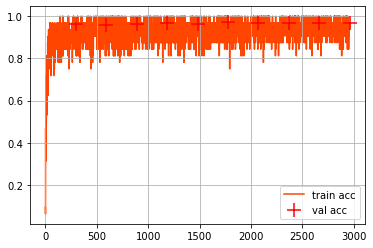

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# Zero init + trainable FE
model_ft = models.resnet18(pretrained=True)
# Соберите модель правильно
# replace final layer, zero initialization
model_ft.fc = nn.Linear(in_features=512, out_features=10, bias=True)
model_ft.fc.weight.data.fill_(0.0)

# trainable feature extractor
for params in model_ft.parameters():
    params.requires_grad = True

optimizer = torch.optim.SGD(list(model_ft.parameters()), lr=0.001, momentum=0.9)
train_model(model_ft, optimizer, train_loader, val_loader, epochs=10)

**Какой вариант работает лучше?**

У вариантов с дообучением Feature Extractor немного лучше accuracy на train сете, но на валидационном разница не заметна, и сам процесс идет В РАЗЫ дольше
По варианту с нулевой инициализацией: ожидание - будет какая-то засада, реальность - как будто бы ничего не поменялось...

Вывод: выбираем #1 (transfer learning, с обучением только последнего слоя и рандомной инициализацией)